In [21]:
import numpy as np
np.random.seed(42)

from sklearn.metrics import mean_squared_error

# Linear Regression model

## Without Regularization
1. $\hat{Y}_{n\times 1} = X_{n\times d}W_{d\times 1}$
2. $\mathcal{L}$ = $(Y-\hat{Y})^T(Y-\hat{Y})$
3. $\nabla{L(\hat{Y}})$ = 2($X^TXW - X^TY$)
4. using this, $W = (X^TX)^{-1}X^TY$

## L1 Regularization
1. $\mathcal{L}$ = $(Y-\hat{Y})^T(Y-\hat{Y})$ + $\lambda ||W||_1$
2. $\nabla{L(\hat{Y}})$ = 2($X^TXW - X^TY$) + $\lambda \begin{bmatrix}
    sign(w_1) \\
    sign(w_2) \\
    \vdots \\
    sign(w_d) \\
\end{bmatrix}_{d\times 1}
$
3. using this, $W = (X^TX)^{-1}\left(X^TY-\frac{1}{2}\lambda \begin{bmatrix}
    sign(w_1) \\
    sign(w_2) \\
    \vdots \\
    sign(w_d) \\
\end{bmatrix}\right)$
4. due to the existence of W on both sides of the solution, this can be solved only using iterative gradient descent approach.

## L2 Regularization
1. $\mathcal{L}$ = $(Y-\hat{Y})^T(Y-\hat{Y})$ + $\lambda ||W||_2$ = $(Y-\hat{Y})^T(Y-\hat{Y})$ + $\lambda W^T.W$
2. $\nabla{L(\hat{Y}})$ = 2($X^TXW - X^TY$) + $2\lambda W$
3. using this, $W = (X^TX + \lambda I_{d\times d})^{-1}X^TY = (X^TX)^{-1}X^TY + \frac{1}{\lambda} X^TY$

In [22]:
class MyLinearRegressor():
    def __init__(self, reg=None, lambda_c=1, bias = 0.1, learning_rate=0.01, epochs=100, tol = 0.0001):
        self.bias = bias
        self.learning_rate = learning_rate
        self.epochs=epochs
        self.tol = tol
        self.loss_arr = []
        self.mse_arr = [] # this is what we are ultimately interested in
        if reg not in ('l1', 'l2', None):
            raise Exception("Invalid value of reg argument passed, allowed values: [l1, l2, None]")
        else:
            if reg is not None and (lambda_c is None or type(lambda_c) not in (int, float, np.int64, np.float64) or lambda_c <= 0):
                raise Exception("Invalid value of regularization parameter passed, Please pass a positive value")
            
        self.reg = reg # regularization method
        self.lambda_c = lambda_c # regularization parameter

    def weight_update(self, gradient):
        self.weight -= self.learning_rate*gradient

    def loss(self, X, y):
        y_hat = self.predict(X)
        non_reg_loss = np.dot((y-y_hat).T, y-y_hat)
        reg_loss_term = 0
        if self.reg =='l1':
            reg_loss_term = self.lambda_c*np.abs(self.weight).sum()
        elif self.reg == 'l2':
            reg_loss_term = self.lambda_c*self.weight.T.dot(self.weight)
        else:
            reg_loss_term = 0
        return non_reg_loss + reg_loss_term

    def fit(self, X, y):
        # dimensionality check
        if X.shape[0] != y.shape[0]:
            raise Exception(f"Given input arrays have unequal shapes, X = {X.shape}, y = {y.shape}")
        x_new = X.copy()
        x_new = np.column_stack((x_new, np.ones((X.shape[0],1))))
        try:
            self.weight = np.dot(np.dot(np.linalg.inv(np.dot(x_new.T, x_new)), x_new.T), y) # (X^T.X)^-1.X^T.y
            if self.reg is not None:
                # l1 regularization
                if self.reg == 'l1':
                    raise np.linalg.LinAlgError("") # l1 can be solved using iterative approach only
                    # weight_sign_mat = self.weight/np.abs(self.weight)
                    # self.weight -= 0.5*self.lambda_c*np.linalg.inv(np.dot(x_new.T, x_new)).dot(weight_sign_mat)
                else:
                    # l2 regularization
                    self.weight -= x_new.T.dot(y)/self.lambda_c
            self.loss_arr.append(self.loss(X, y))
            self.mse_arr.append(mean_squared_error(self.predict(X), y))
                
        except np.linalg.LinAlgError as e:
            print("Weight matrix is non-invertible, will solve using epochs.")
            # matrix was non-invertible, would've to solve iteratively
            d = X.shape[1]
            self.weight = np.random.uniform(-1, 1, (d,1)) # initialize weight vector
            self.weight = np.row_stack((self.weight, np.array([self.bias]))).round(3) # add bias term as d+1'th row
            # print(f"X shape = {X.shape}, x_new shape = {x_new.shape}, w shape = {self.weight.shape}, y shape = {y.shape}")
            self.mse_arr.append(mean_squared_error(self.predict(X), y))
            
            for i in range(self.epochs):
                self.loss_arr.append(self.loss(X, y))
                gradient = 2*(np.dot(np.dot(x_new.T, x_new), self.weight) - np.dot(x_new.T, y)[:, np.newaxis])
                additional_term = np.zeros(self.weight.shape)
                if self.reg in ('l1', 'l2'):
                    if self.reg == 'l1':
                        additional_term = self.lambda_c * np.sign(self.weight)
                    else:
                        additional_term = 2*self.weight*self.lambda_c
                self.weight_update(gradient+additional_term)
                self.mse_arr.append(mean_squared_error(self.predict(X), y))

    def predict(self, X_test):
        # y^ = X.w
        x_new = X_test.copy()
        x_new = np.column_stack((x_new, np.ones((x_new.shape[0],1))))
        y_hat = np.dot(x_new, self.weight) 
        return np.squeeze(y_hat)

In [23]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the Diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## No Regularization

In [6]:
mlr = MyLinearRegressor()
mlr.fit(X_train, y_train)

mlr_mse = mean_squared_error(mlr.predict(X_test), y_test)
print(f"MSE of my non-regularized linear regressor is {mlr_mse.round(4)}")

MSE of my non-regularized linear regressor is 2900.1936


## L1 Regularization

In [28]:
mlr_l1_c_30 = MyLinearRegressor(reg='l1', lambda_c = 30)
mlr_l1_c_30.fit(X, y)

mlr_l1_c_30_mse = mean_squared_error(mlr_l1_c_30.predict(X_test), y_test)
print(f"MSE of my L1-regularized linear regressor with alpha=30 is {mlr_l1_c_30_mse.round(4)}")

Weight matrix is non-invertible, will solve using epochs.
MSE of my L1-regularized linear regressor with alpha=30 is 1.68618165375052e+183


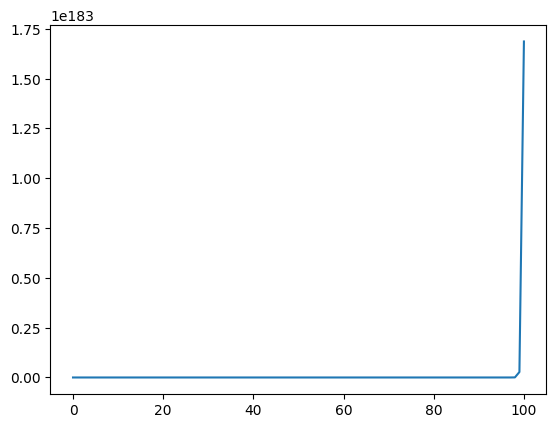

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(len(mlr_l1_c_30.mse_arr)), mlr_l1_c_30.mse_arr)
plt.show()

Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.


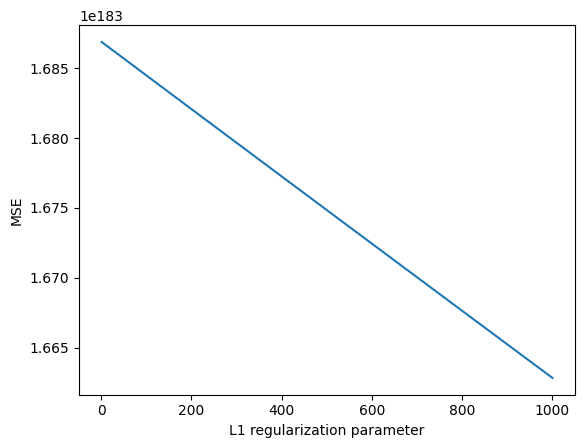

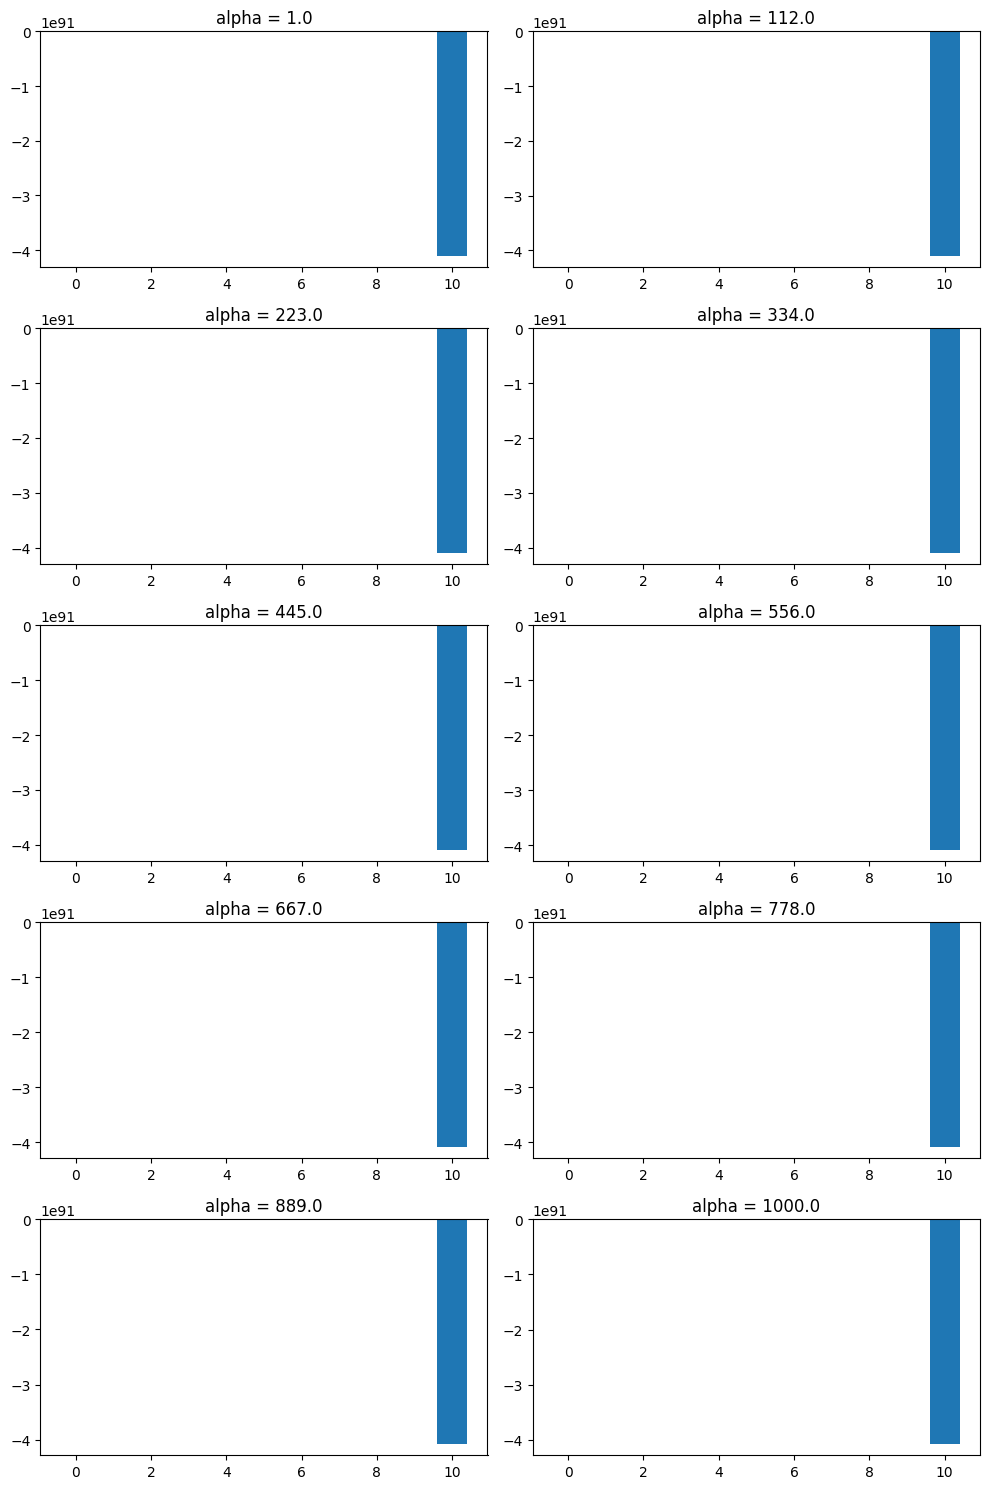

In [30]:
lambda_c_arr = np.linspace(1, 1000, 10).round(3)
mlr_l1_mse_arr, mlr_l1_weight_arr = [], []
for lambda_val in lambda_c_arr:
    mlr_l1_c_custom = MyLinearRegressor(reg='l1', lambda_c = lambda_val)
    mlr_l1_c_custom.fit(X, y)
    mlr_l1_mse_arr.append(mean_squared_error(mlr_l1_c_custom.predict(X_test), y_test))
    mlr_l1_weight_arr.append(mlr_l1_c_custom.weight.reshape(mlr_l1_c_custom.weight.shape[0],))

import matplotlib.pyplot as plt
plt.xlabel('L1 regularization parameter');plt.ylabel('MSE')
plt.plot(lambda_c_arr, mlr_l1_mse_arr);plt.show()

n_weight_dim = mlr_l1_weight_arr[0].shape[-1]
x_list = range(n_weight_dim)

# print(mlr_l1_weight_arr)

fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(10):
    r, c = int(i/2), i%2
    ax[r][c].bar(x_list, mlr_l1_weight_arr[i])
    ax[r][c].set_title(f"alpha = {lambda_c_arr[i]}")
plt.tight_layout()
plt.show()

## L2 Regularization

In [55]:
mlr_l2_c_10 = MyLinearRegressor(reg='l2', lambda_c = 10)
mlr_l2_c_10.fit(X, y)

mlr_l2_c_10_mse = mean_squared_error(mlr_l2_c_10.predict(X_test), y_test)
print(f"MSE of my L2-regularized linear regressor with C=1/10 is {mlr_l2_c_10_mse.round(4)}")

mlr_l2_c_500 = MyLinearRegressor(reg='l2', lambda_c = 500)
mlr_l2_c_500.fit(X, y)

mlr_l2_c_500_mse = mean_squared_error(mlr_l2_c_500.predict(X_test), y_test)
print(f"MSE of my L2-regularized linear regressor with C=1/500 is {mlr_l2_c_500_mse.round(4)}")

MSE of my L2-regularized linear regressor with C=1/10 is 45225475.5739
MSE of my L2-regularized linear regressor with C=1/500 is 21573.8493


## Compare performance with scikit-learn's LinearRegression

In [31]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train, y_train)

sklearn_lr_mse = mean_squared_error(lr.predict(X_test), y_test)
print(f"MSE of sklearn's linear regressor = {sklearn_lr_mse.round(4)}")

lasso_lr = Lasso(alpha=30)
lasso_lr.fit(X_train, y_train)

sklearn_lasso_lr_mse = mean_squared_error(lasso_lr.predict(X_test), y_test)
print(f"MSE of sklearn's lasso regressor = {sklearn_lasso_lr_mse.round(4)}")

ridge_lr = Ridge(alpha=100)
ridge_lr.fit(X_train, y_train)

sklearn_ridge_lr_mse = mean_squared_error(ridge_lr.predict(X_test), y_test)
print(f"MSE of sklearn's Ridge regressor = {sklearn_ridge_lr_mse.round(4)}")

MSE of sklearn's linear regressor = 2900.1936
MSE of sklearn's lasso regressor = 5361.5335
MSE of sklearn's Ridge regressor = 5233.6637


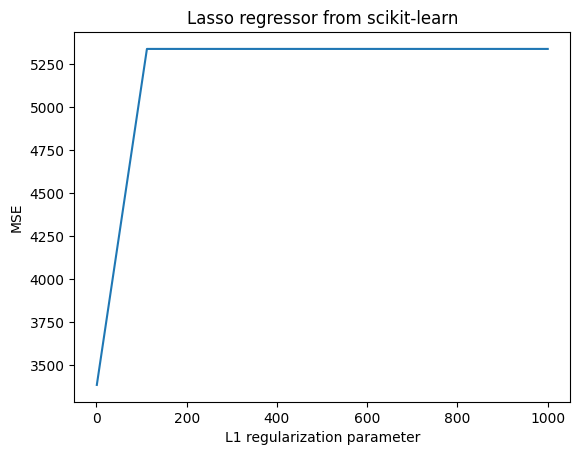

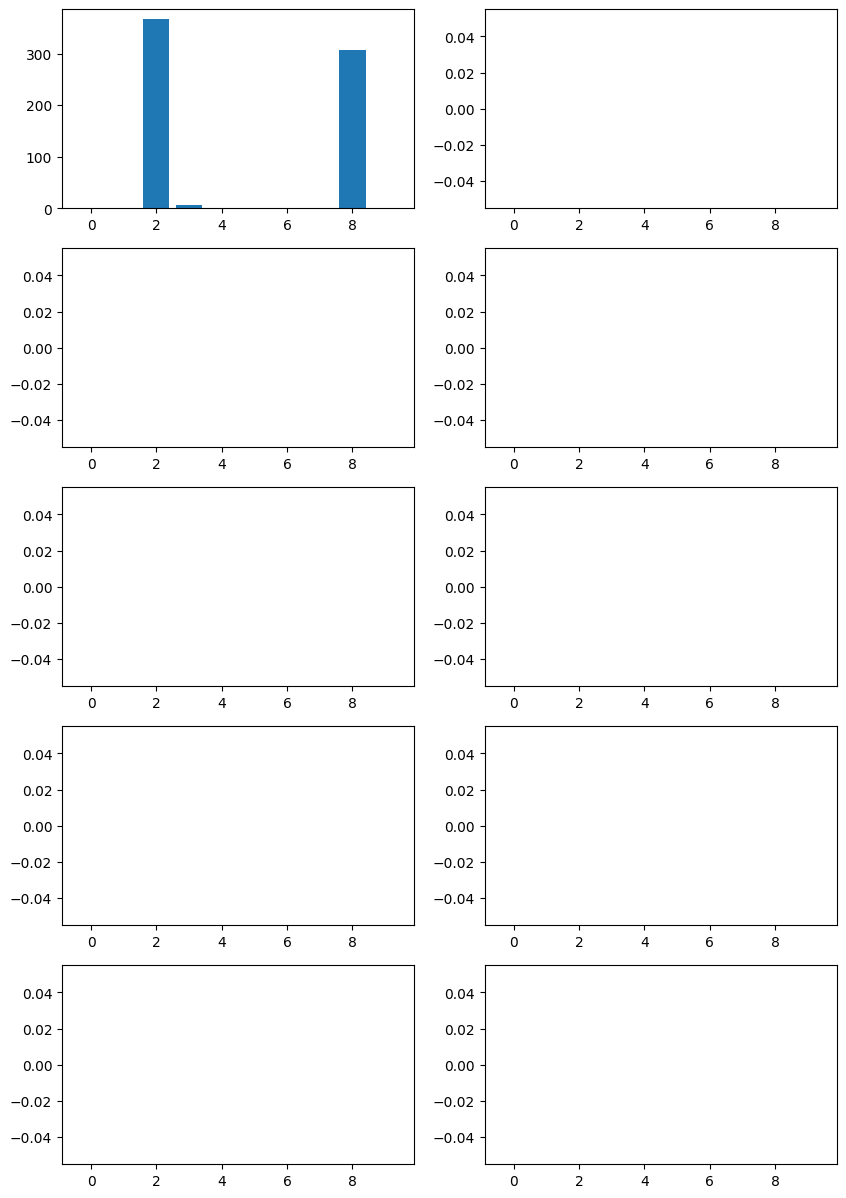

In [36]:
sklearn_l1_mse_arr, sklearn_l1_weight_arr = [], []
for lambda_val in lambda_c_arr:
    sklearn_l1_c_custom = Lasso(alpha=lambda_val)
    sklearn_l1_c_custom.fit(X, y)
    sklearn_l1_mse_arr.append(mean_squared_error(sklearn_l1_c_custom.predict(X_test), y_test))
    sklearn_l1_weight_arr.append(sklearn_l1_c_custom.coef_)

import matplotlib.pyplot as plt
plt.xlabel('L1 regularization parameter');plt.ylabel('MSE');plt.title("Lasso regressor from scikit-learn")
plt.plot(lambda_c_arr, sklearn_l1_mse_arr);plt.show()

n_weight_dim = sklearn_l1_weight_arr[0].shape[-1]
x_list = range(n_weight_dim)

fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(10):
    r, c = int(i/2), i%2
    ax[r][c].bar(x_list, sklearn_l1_weight_arr[i])    
plt.show()

<font size="3">This difference in weight values and loss-curve w.r.t. regularization parameter $\lambda$(a.k.a. $\alpha$) is because `sklearn` uses coordinate descent as its optimization method, instead of regular gradient descent.</font>

<font size="4">To make our model competitive, either we need to move to coordinate descent method, or </font><font size="5">**change the `learning_rate` value $\eta$**</font>

Weight matrix is non-invertible, will solve using epochs.
MSE of my L1-regularized linear regressor with alpha=30 is 2772.6818


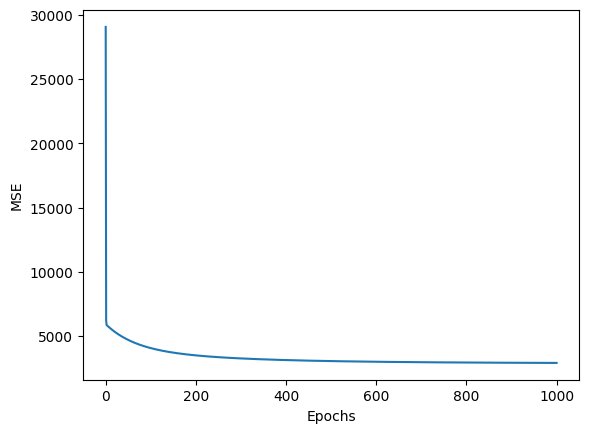

In [34]:
mlr_l1_c_30 = MyLinearRegressor(reg='l1', lambda_c = 30, learning_rate = 0.001, epochs = 1000) # since max_iteration value of Lasso class is 1000.
mlr_l1_c_30.fit(X, y)

mlr_l1_c_30_mse = mean_squared_error(mlr_l1_c_30.predict(X_test), y_test)
print(f"MSE of my L1-regularized linear regressor with alpha=30 is {mlr_l1_c_30_mse.round(4)}")

import matplotlib.pyplot as plt
plt.plot(range(len(mlr_l1_c_30.mse_arr)), mlr_l1_c_30.mse_arr)
plt.xlabel('Epochs');plt.ylabel('MSE')
plt.show()

Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.
Weight matrix is non-invertible, will solve using epochs.


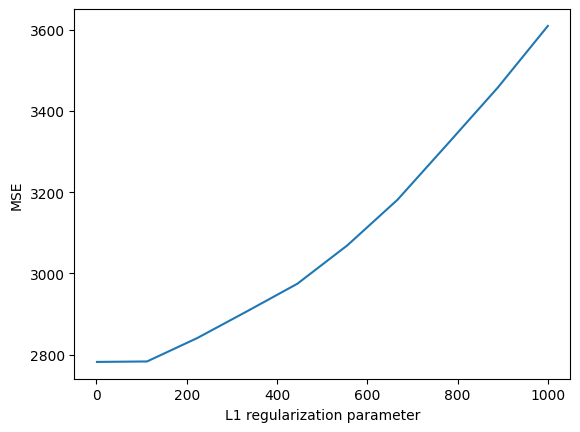

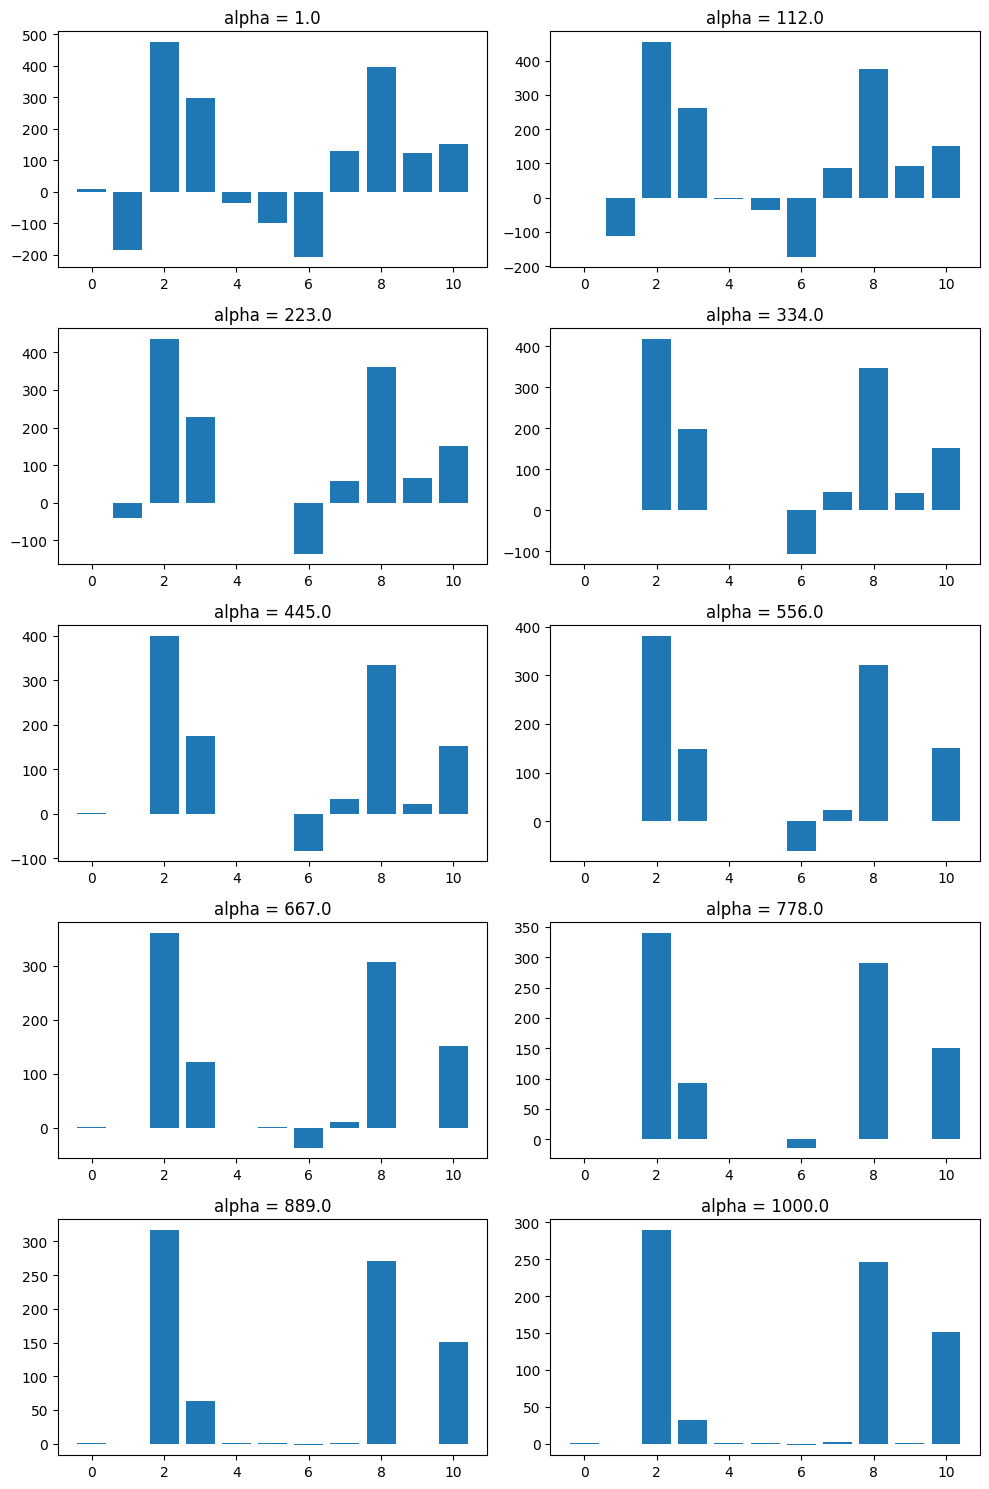

In [35]:
mlr_l1_mse_arr, mlr_l1_weight_arr = [], []
for lambda_val in lambda_c_arr:
    mlr_l1_c_custom = MyLinearRegressor(reg='l1', lambda_c = lambda_val, learning_rate = 0.001, epochs = 1000)
    mlr_l1_c_custom.fit(X, y)
    mlr_l1_mse_arr.append(mean_squared_error(mlr_l1_c_custom.predict(X_test), y_test))
    mlr_l1_weight_arr.append(mlr_l1_c_custom.weight.reshape(mlr_l1_c_custom.weight.shape[0],))

import matplotlib.pyplot as plt
plt.xlabel('L1 regularization parameter');plt.ylabel('MSE')
plt.plot(lambda_c_arr, mlr_l1_mse_arr);plt.show()

n_weight_dim = mlr_l1_weight_arr[0].shape[-1]
x_list = range(n_weight_dim)

# print(mlr_l1_weight_arr)

fig, ax = plt.subplots(5, 2, figsize=(10,15))
for i in range(10):
    r, c = int(i/2), i%2
    ax[r][c].bar(x_list, mlr_l1_weight_arr[i])
    ax[r][c].set_title(f"alpha = {lambda_c_arr[i]}")
plt.tight_layout()
plt.show()

### Intuitive Explanation of why Coordinate Descent is preferred
Only tunable hyperparameter = $\lambda$, whereas for vanilla gradient descent there are 2, $\lambda$ and $\eta$(learning rate)

## Why Regularization works.
1. applied when a weight hyperparameter becomes too large.
2. instead of the usual gradient update: $w = w_0 - \eta.\frac{\partial \mathcal{L}}{\partial w_0}$ , we rather have $w = w_0 - \eta.\left[\frac{\partial \mathcal{L}}{\partial w_0} + \lambda w_0 \right] \Rightarrow (1-\eta\lambda)w_0 - \eta\frac{\partial \mathcal{L}}{\partial w_0}$
3. hence, a fraction of the original weight is taken $(1-\eta\lambda)$ while performing the gradient update.

# Logistic Regressor
- used for binary classification
- $z_i = X^{(i)}_{1\times d}W_{d\times 1}$
- $\hat{y_i} = g(z_i)$ , $g(z_i) = 1/(1+e^{-z_i})$ , g(z) is also known as sigmoid function, having property $\frac{\partial \sigma(z)}{\partial z} = \sigma(z)(1-\sigma(z))$
- $\mathcal{L} = -\left(\sum_{i}y_i\ln(\hat{y_i}) + (1-y_i)\ln(1-\hat{y_i}) \right)$
- $\nabla{\mathcal{L}^{(j)}(\hat{Y})}$ = $\frac{\partial \mathcal{L}}{\partial W^{(j)}}$ = $\frac{\partial \mathcal{L}}{\partial \hat{Y}}\frac{\partial \hat{Y}}{\partial W^{(j)}}$
  - $\frac{\partial \mathcal{L}}{\partial \hat{Y}}$ = $-\left( \frac{y}{\hat{y}} - \frac{(1-y)}{(1-\hat{y})} \right)$
  - $\frac{\partial \hat{Y}}{\partial W^{(j)}}$ = $X^T_j \hat{Y}(1-\hat{Y})$
  - $\nabla{\mathcal{L}^{(j)}(\hat{Y})}$ = $-\left(X^T_j.(Y-\hat{Y})  \right)$
- $W^{(j)}$ = $W^{(j)}$ - $\eta \left( \nabla{\mathcal{L}^{(j)}(\hat{Y})} \right)$

## Code Implementation
- <font color="red">Note:</font> Study the np.clip function.

In [5]:
import numpy as np
np.random.seed(42)

def sigmoid(x):
    return 1/(1+np.exp(-x))

class MyLogisticRegressor():
    def __init__(self, learning_rate = 0.001, epochs = 1000, tol = 0.0001):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss_arr = []
        self.tol = tol
    def update(self, X, y):
        z = X.dot(self.weight)
        y_hat = sigmoid(z)
        gradient = X.T.dot(y_hat - y)
        self.weight -= self.learning_rate * gradient
    def loss(self, X, y):
        """
        clipping is used to avoid np.nan if log(0) ever needs to be calculated.
        y_hat values below epsilon would be changed to epsilon, whose log can be calculated.
        """
        # logloss function
        y_hat = sigmoid(X.dot(self.weight))
        epsilon = 1e-15
        y_hat_clipped = np.clip(y_hat, epsilon, 1-epsilon)
        loss_val = (y*np.log(y_hat_clipped) + (1-y)*np.log(1-y_hat_clipped))
        return -(loss_val.sum())
    def fit(self, X, y):
        y = y.copy()
        y = y.reshape((y.shape[0], 1))
        x_new = X.copy()
        x_new = np.hstack((x_new, np.ones((X.shape[0], 1)))) # add a column of 1's for the bias
        self.weight = np.random.random((x_new.shape[1], 1))

        curr_loss, prev_loss = self.loss(x_new, y), None
        self.loss_arr.append(round(curr_loss, 5))
        for _ in range(self.epochs):
            self.update(x_new, y)
            prev_loss = curr_loss
            curr_loss = self.loss(x_new, y)
            self.loss_arr.append(curr_loss)
    def predict(self, X):
        x_new = X.copy()
        x_new = np.hstack((x_new, np.ones((X.shape[0], 1)))) # add a column of 1's for the bias
        return sigmoid(x_new.dot(self.weight).reshape(x_new.shape[0],)).round(0)

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
logr = MyLogisticRegressor(epochs = 2000)
logr.fit(X_train, y_train)
y_pred_my_logr = logr.predict(X_test)
print(y_pred_my_logr)

[0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1.]


/var/folders/w9/wpf4tzps31g9gkyyfw7j56c00000gn/T/ipykernel_10113/3780292162.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


## Comparison with scikit-learn's Logistic Regressor

In [8]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(penalty=None,)
logR.fit(X_train, y_train)
y_pred_sklearn_logr = logR.predict(X_test)
print(y_pred_sklearn_logr)

[1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0
 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


/Users/akshayprabhakant/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
from sklearn.metrics import log_loss as logloss
print(f"Log loss from scikit learn Logistic Regressor = {logloss(y_test, y_pred_sklearn_logr)}")
print(f"Log loss from My Logistic Regressor = {logloss(y_test, logr.predict(X_test))}")

Log loss from scikit learn Logistic Regressor = 0.8431263950670681
Log loss from My Logistic Regressor = 2.5293791852012038


/var/folders/w9/wpf4tzps31g9gkyyfw7j56c00000gn/T/ipykernel_10113/3780292162.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


# Softmax Logistic Regression
1. $\mathcal{L} = \sum\limits_i\sum\limits_c Y_{i,c} \ln \hat{Y}_{i,c}$ ; where i: i'th sample, c: c'th class
     1. $Y_{i,c} = 0$ if i'th sample doesn't belong to class c else 1.
     2. $Y_{i}$ = one-hot encoded row-vector.
3. $\hat{Y}_{i,c}$ = softmax$\left(z_{i,c} \right)$
4. softmax$\left(z_{i,c} \right)$ = $e^{z_{i,c}}/\left(\sum\limits_c e^{z_{i,c}}\right)$
5. $z_{i,c}$ = $X_i.W_c$ , $W_c = {d\times 1}$, $W_c$: weight matrix for class c.

- $\nabla{\mathcal{L}^{(j)}(\hat{Y})}$ = $\frac{\partial \mathcal{L}}{\partial W^{(j)}}$
    - $\sum\limits_i\sum\limits_c Y_{i,c}  \ln \hat{Y}_{i,c}$ = $\sum\limits_i\sum\limits_c Y_{i,c} \left(z_{i,c}- ln\left(\sum\limits_c e^{z_{i,c}}\right)\right)/$

In [2]:
def softmax(x):
    exp_arr = np.exp(x) # x: n x C ==> exp_arr: n x C
    exp_sum = np.sum(exp_arr, axis=1) # (n,)
    return exp_arr/exp_sum[:, np.newaxis] # this reshapes the exp_sum array to 2d, i.e. (n,1)

class MyMultiClassLogisticRegressor():
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.loss_arr = []

    def update(self, X, y):
        z = X.dot(self.weight) # n x C
        y_proba = softmax(z) # n X C
        gradient = -X.T.dot(y - y_proba)
        self.weight -= self.learning_rate * gradient

    def loss(self, X, y):
        """
        y: n x C , X: n x d
        """
        z = X.dot(self.weight) # n x C matrix
        y_proba = softmax(z)         # n x C matrix
        epsilon = 1e-15
        y_proba = np.clip(y_proba, epsilon, 1-epsilon) # n x C
        y_hat_ln = np.log(y_proba) # n x C
        loss_matrix = y.dot(y_hat_ln.T) 
        return -np.trace(loss_matrix)

    def fit(self, X, y):
        """
        X: n x d matrix, 
        y: n x C matrix, one-hot encoded, eg. y_i = class-2 , then y_i = [0 1 0] with C=3
        """
        x_new = X.copy()
        x_new = np.hstack((x_new, np.ones((x_new.shape[0], 1)))) # add a column of 1's for bias
        y_ohe = pd.get_dummies(y) # one-hot encoding
        d, C = x_new.shape[1], y_ohe.shape[1] # C: number of classes
        self.weight = np.random.random((d, C)) # initialize d x C matrix
        for _ in range(self.epochs):
            self.loss_arr.append(self.loss(x_new, y_ohe))
            self.update(x_new, y_ohe)

    def predict(self, X):
        y_proba = self.predict_proba(X)
        y_hat_ohe = np.where(y_proba == y_proba.max(axis=1)[:, np.newaxis], 1, 0)
        return np.argmax(y_hat_ohe, axis=1)
        
    def predict_proba(self, X):
        x_new = X.copy()
        x_new = np.hstack((x_new, np.ones((x_new.shape[0], 1)))) # add a column of 1's for bias
        z = x_new.dot(self.weight) # n x C matrix
        y_hat = softmax(z)         # n x C matrix
        return y_hat # return a n x C matrix, C: number of classes

Prepare the dataset

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import pandas as pd

iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/akshayprabhakant/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
my_multi_logr = MyMultiClassLogisticRegressor()
print(X_train_scaled.shape, y_train.shape)
my_multi_logr.fit(X_train_scaled, y_train)

(120, 4) (120,)


In [5]:
# Make predictions on the test data
y_pred_my_multi_logr = my_multi_logr.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_my_multi_logr)
print("Accuracy:", accuracy)

Accuracy: 1.0


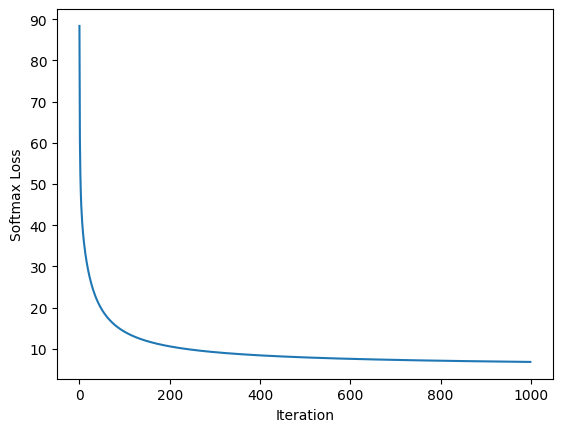

In [6]:
import matplotlib.pyplot as plt
plt.xlabel('Iteration');plt.ylabel('Softmax Loss')
plt.plot(np.arange(len(my_multi_logr.loss_arr)), my_multi_logr.loss_arr)
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression

sklearn_multi_logr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
# Fit the model to the training data
sklearn_multi_logr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_sklearn_multi_logr = sklearn_multi_logr.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_sklearn_multi_logr)
print("Accuracy:", accuracy)

Accuracy: 1.0


Let's see how both perform on non-standardized data

In [8]:
my_multi_logr_nonstd = MyMultiClassLogisticRegressor()
my_multi_logr_nonstd.fit(X_train, y_train)

# Make predictions on the test data
y_pred_my_multi_logr_nonstd = my_multi_logr_nonstd.predict(X_test)

# Calculate accuracy
accuracy_my_multi_logr_nonstd = accuracy_score(y_test, y_pred_my_multi_logr_nonstd)

sklearn_multi_logr_nonstd = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
# Fit the model to the training data
sklearn_multi_logr_nonstd.fit(X_train, y_train)

# Make predictions on the test data
y_pred_sklearn_multi_logr_nonstd = sklearn_multi_logr_nonstd.predict(X_test)

# Calculate accuracy
accuracy_sklearn_multi_logr_nonstd = accuracy_score(y_test, y_pred_sklearn_multi_logr_nonstd)
print(f"Accuracy of my multinomial logistic regressor on non-standardized data = {accuracy_my_multi_logr_nonstd}\nAccuracy of scikit-learn's multinomial logistic regressor on non-standardized data = {accuracy_sklearn_multi_logr_nonstd}")

Accuracy of my multinomial logistic regressor on non-standardized data = 1.0
Accuracy of scikit-learn's multinomial logistic regressor on non-standardized data = 1.0


# Support Vector Machines
- Margin Maximization algorithm
- after obtaining the hyperplane that maximizes margin($\Pi$), i.e. **decision boundary**,
    - $\Pi_+$, $\Pi_-$ , separated by distance $d$.
    - The points that pass through $\Pi_+$, $\Pi_-$ $\Rightarrow$ Support Vectors
- Why are $\Pi_+$ and $\Pi_-$ equidistant?
- Why $W^TX+b=0?$ and not =c?